In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import zipfile

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_imagenrator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_imagenrator = ImageDataGenerator(rescale=1./255)

batch_size = 64
image_shape = (256, 256)

train_generator = train_imagenrator.flow_from_directory(
    '/kaggle/input/teeth-dataset/Teeth DataSet/Teeth_Dataset/Training',
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
)
val_generator = val_imagenrator.flow_from_directory(
    '/kaggle/input/teeth-dataset/Teeth DataSet/Teeth_Dataset/Validation',
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
)
test_generator = val_imagenrator.flow_from_directory(
    '/kaggle/input/teeth-dataset/Teeth DataSet/Teeth_Dataset/Testing',
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
class_names = list(train_generator.class_indices.keys())

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Step 1: Get class indices from train_generator
labels = train_generator.classes  # array of class indices, e.g., [0, 1, 1, 2, 0, ...]

# Step 2: Get the list of unique class labels
class_labels = np.unique(labels)

# Step 3: Compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=labels)

# Step 4: Map class weights to dictionary format required by Keras
class_weights_dict = dict(zip(class_labels, class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: 0.91875, 1: 0.98, 2: 1.225, 3: 0.8166666666666667, 4: 1.3611111111111112, 5: 0.8166666666666667, 6: 1.1221374045801527}


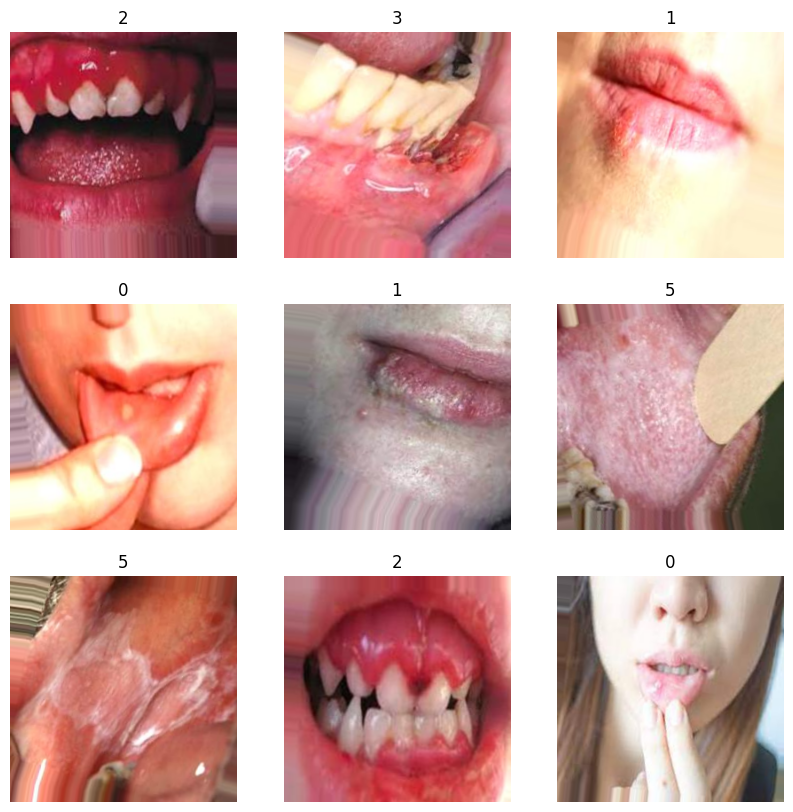

In [5]:
augmented_image, label = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[i])
    plt.title(np.argmax(label[i]))
    plt.axis("off")


### MobileNet


In [6]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(256, 256, 3),
    weights='imagenet',
    include_top=False
)
pretrained_model.trainable = False

/tmp/ipykernel_1893/642438894.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model = tf.keras.applications.MobileNetV2(
I0000 00:00:1752185224.157455    1893 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
pretrained_model.trainable = True

inputs = keras.Input(shape=(256, 256, 3))
x = pretrained_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dropout(0.7)(x)

x = keras.layers.BatchNormalization()(x)

output = keras.layers.Dense(7, activation='softmax')(x)

model = keras.Model(inputs, output)

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,272,071 (8.67 MB)

 Trainable params: 2,235,399 (8.53 MB)

 Non-trainable params: 36,672 (143.25 KB)

In [9]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1752185277.869075    1966 service.cc:148] XLA service 0x7b6d70002820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752185277.869131    1966 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1752185281.459586    1966 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1752185286.391603    1966 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752185286.587315    1966 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 1/49 ━━━━━━━━━━━━━━━━━━━━ 44:57 56s/step - accuracy: 0.0000e+00 - loss: 2.6553

I0000 00:00:1752185297.311665    1966 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
E0000 00:00:1752185307.875694    1969 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752185308.073841    1969 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


49/49 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.4809 - loss: 1.5219 - val_accuracy: 0.1955 - val_loss: 9.6005
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8706 - loss: 0.3837 - val_accuracy: 0.2617 - val_loss: 7.3049
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9220 - loss: 0.2358 - val_accuracy: 0.2335 - val_loss: 9.4344
Epoch 4/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9482 - loss: 0.1656 - val_accuracy: 0.2228 - val_loss: 13.4695


In [11]:
pretrained_model.trainable = True

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9331 - loss: 0.2295 - val_accuracy: 0.2977 - val_loss: 6.7339 - learning_rate: 1.0000e-05
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9396 - loss: 0.1660 - val_accuracy: 0.3278 - val_loss: 6.3314 - learning_rate: 1.0000e-05
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9490 - loss: 0.1552 - val_accuracy: 0.3658 - val_loss: 5.8670 - learning_rate: 1.0000e-05
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9568 - loss: 0.1361 - val_accuracy: 0.4027 - val_loss: 5.4823 - learning_rate: 1.0000e-05
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9677 - loss: 0.1127 - val_accuracy: 0.4368 - val_loss: 5.0599 - learning_rate: 1.0000e-05
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9691 - loss: 0.1019 - val_accuracy: 0.4650 - val_loss: 4.6880 - learning_rate: 1.0000e-05
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.9761 - loss

Text(0, 0.5, 'Accuracy')

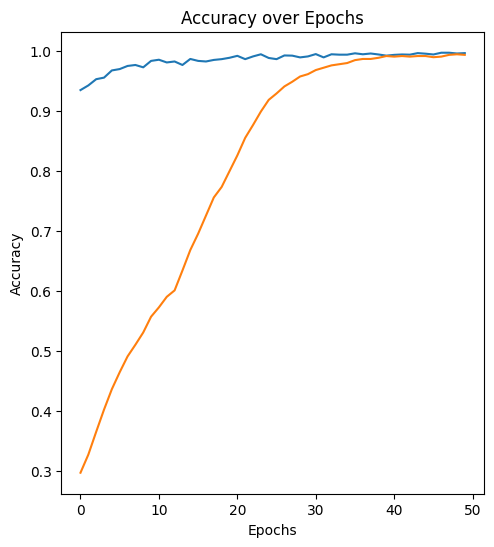

In [14]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


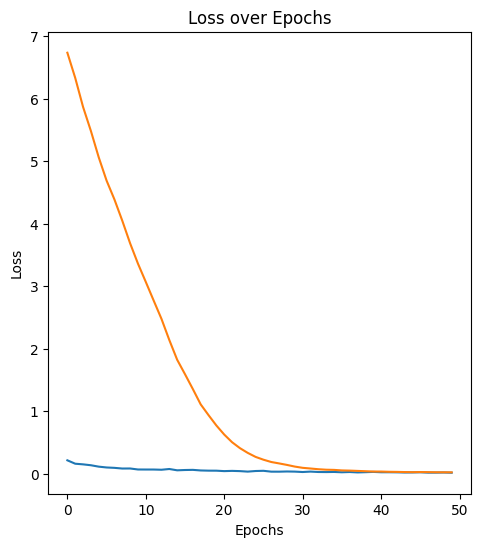

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 469ms/step


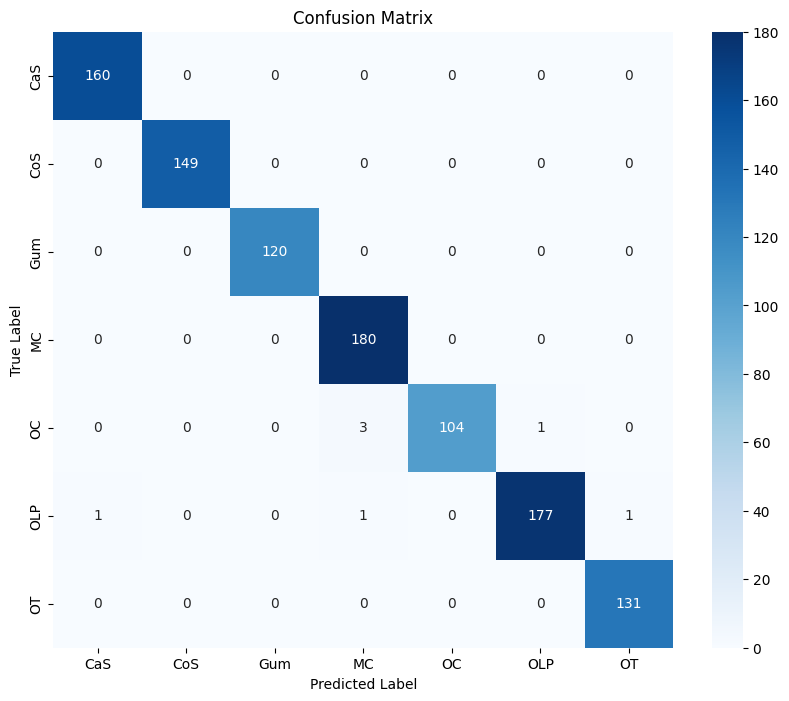

              precision    recall  f1-score   support

         CaS       0.99      1.00      1.00       160
         CoS       1.00      1.00      1.00       149
         Gum       1.00      1.00      1.00       120
          MC       0.98      1.00      0.99       180
          OC       1.00      0.96      0.98       108
         OLP       0.99      0.98      0.99       180
          OT       0.99      1.00      1.00       131

    accuracy                           0.99      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028



In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# IMPORTANT: make sure shuffle=False in test_generator
# test_generator = ImageDataGenerator(..., shuffle=False)

# Predict all test data
preds = model.predict(test_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)

# True labels (correct order now!)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))


In [17]:
model.save('mobileNet_model.h5')

### EfficientNet


In [18]:
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

pretrained_model.trainable = False

In [19]:
pretrained_model.trainable = True

inputs = keras.Input(shape=(256, 256, 3))
x = pretrained_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dropout(0.7)(x)

x = keras.layers.BatchNormalization()(x)

output = keras.layers.Dense(7, activation='softmax')(x)

model = keras.Model(inputs, output)

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,063,658 (15.50 MB)

 Trainable params: 4,019,075 (15.33 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)

Epoch 1/5


E0000 00:00:1752188559.313273    1967 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752188559.509657    1967 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752188560.067957    1967 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752188560.275918    1967 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752188560.660046    1967 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

 6/49 ━━━━━━━━━━━━━━━━━━━━ 38s 891ms/step - accuracy: 0.1582 - loss: 2.5024

E0000 00:00:1752188599.226634    1967 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752188599.411845    1967 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752188599.861115    1967 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752188600.066315    1967 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752188600.428578    1967 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

49/49 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.4204 - loss: 1.6978 - val_accuracy: 0.1751 - val_loss: 1.9408
Epoch 2/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8722 - loss: 0.3620 - val_accuracy: 0.1167 - val_loss: 1.9976
Epoch 3/5
49/49 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9451 - loss: 0.1565 - val_accuracy: 0.1449 - val_loss: 2.9985


In [23]:
pretrained_model.trainable = True

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8478 - loss: 0.4192 - val_accuracy: 0.1770 - val_loss: 1.9478 - learning_rate: 1.0000e-05
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8641 - loss: 0.4001 - val_accuracy: 0.1362 - val_loss: 1.9602 - learning_rate: 1.0000e-05
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8664 - loss: 0.3892 - val_accuracy: 0.1751 - val_loss: 1.9891 - learning_rate: 1.0000e-05
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8700 - loss: 0.3633
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
49/49 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8702 - loss: 0.3631 - val_accuracy: 0.1440 - val_loss: 2.0594 - learning_rate: 1.0000e-05
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8676 - loss: 0.3797 - val_accuracy: 0.1420 - val_loss: 2.1201 - learning_rate: 5.0000e-06
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8845 - loss: 0.33

Text(0, 0.5, 'Accuracy')

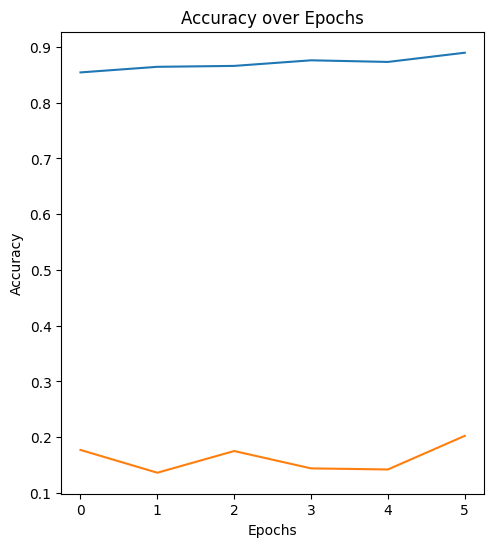

In [29]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


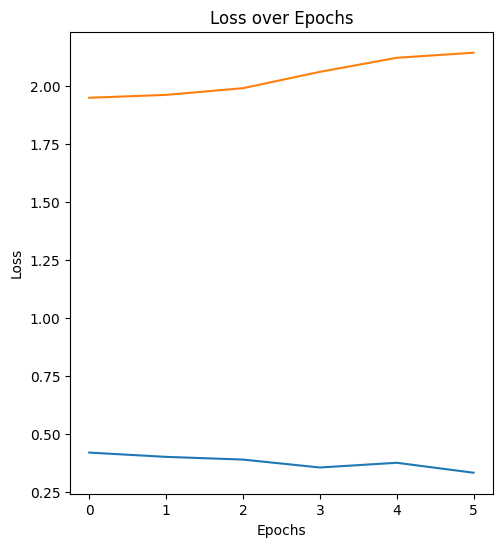

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 644ms/step


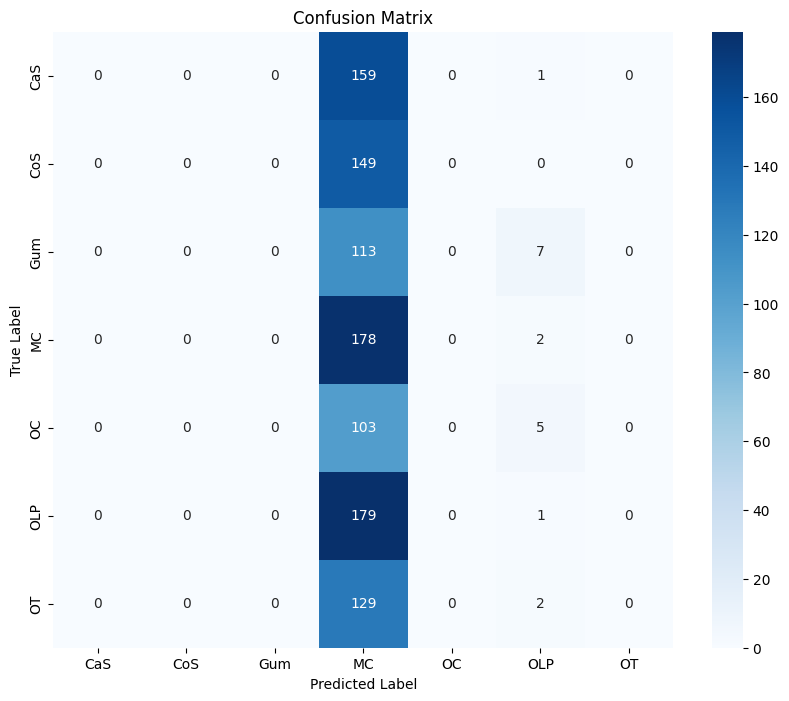

              precision    recall  f1-score   support

         CaS       0.00      0.00      0.00       160
         CoS       0.00      0.00      0.00       149
         Gum       0.00      0.00      0.00       120
          MC       0.18      0.99      0.30       180
          OC       0.00      0.00      0.00       108
         OLP       0.06      0.01      0.01       180
          OT       0.00      0.00      0.00       131

    accuracy                           0.17      1028
   macro avg       0.03      0.14      0.04      1028
weighted avg       0.04      0.17      0.05      1028



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# IMPORTANT: make sure shuffle=False in test_generator
# test_generator = ImageDataGenerator(..., shuffle=False)

# Predict all test data
preds = model.predict(test_generator, verbose=1)
y_pred = np.argmax(preds, axis=1)

# True labels (correct order now!)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))


### EfficeientNet model performed badly


In [31]:
model.save('EfficientNet_model.h5')